# Describing and Rendering a Scene

저번 챕터에서 주어진 2D 좌표를 캔버스에 2D 삼각형을 그리는 알고리즘을 개발하였고.   
**Scene** 에서의 3D 좌표를 **Canvas** 의 2D 좌표로 변환하는 수학 공식을 살펴보았다.   

이전 챕터의 마지막에, 3D 큐브를 2D 캔버스에 그리기 위해 알고리즘과 수학 공식을 사용한 프로그램을 만들었다. 이번 챕터에서는 여러 수의 오브젝트를 포함한 전체 Scene을 렌더링 하는 것을 목표로 하여 작업을 공식화하고 확장할 것이다.  

## Representing a Cube 

일반적인 방법으로 큐브를 표현하고 조작하는 방법에 대해 생각한다.   

큐브의 보서리는 2 units 길이이고, 모서리는 각 축과 평행하다. 또한 큐브의 중심은 원점이다. 

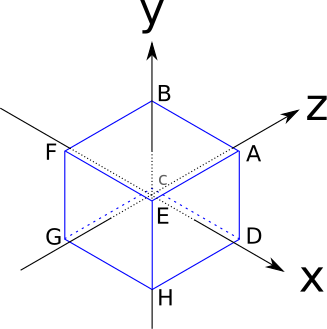

큐브의 측면은 사각형인데, 우리가 개발한 알고리즘은 삼각형으로 작동한다.    
삼각형을 고른 이유는, 사각형을 포함한 다각형이 삼각형으로 분해될 수 있기 때문이다. 
그래서 우리는 큐브의 측면 사각형을 두개의 삼각형을 이용해 표현해야 한다.   

그러나 우리는 큐브의 3개의 꼭짓점을 선택하여, 큐브의 표면에 삼각형을 표현하기를 기대할 수 없다. 예를들어, ADG 는 큐브의 안쪽이다.  
이것은 꼭짓점 좌표만으로 큐브를 완전히 설명할 수 없음을 의미한다. 우리는 어느 꼭짓점 집합이 면을 구성하는 삼각형을 그리는지 알 필요가 있다.   

아래는 우리 큐브에서 가능한 삼각형의 리스트이다.  

```
A, B, C
A, C, D
E, A, D
E, D, H
F, E, H
F, H, G
B, F, G
B, G, C
E, F, B
E, B, A
C, G, H
C, H, D
```

이것은 우리가 삼각형으로 만들어진 물체를 표현하기 위해 사용할 일반적인 구조를 암시한다.   
**Vertices** 리스트는 각 점의 좌표를 가진다. **Triangles** 리스트는 어느 세 점의 집합이 물체 표면의 삼각형을 묘사하는지를 지정한다.   

**Triangles** 리스트에는, 어느 점들이 삼각형을 구성하는지 외에도 추가적인 정보들이 포함될 수 있다. 예를 들어, 각 삼각형의 색을 지정하기에 좋은 장소가 될 수 있다.   

정보를 저장하는 자연스러운 방법이 두개의 리스트에 있기 때문에, 우리는 점 리스트의 점을 표현하기 위해 리스트 인덱스를 사용한다. 우리 큐브는 다음과 같이 표현된다. 

이 표현으로 오브젝트를 렌더링하는 것은 쉽다. 우리는 처음에 모든 점을 투영하여 *temporary projected vertices list* 에 저장한다. 각 점은 평균 4번 사용되기 때문에 반복된 작업을 피할 수 있다. 그 후 *triangle list*를 통해 각 삼각형을 렌더링한다. 

위의 정의를 큐브에 직접 적용할 수 있지만, 결과가 좋지 않다.   
이는 몇개의 점이 카메라의 뒤에 있기 때문이다.   
카메라의 위치가 원점으로 설정되어있는데 이는 큐브의 안쪽이다.   

이를 해결하기 위해, 큐브를 옮길것이다. 큐브를 옮기기 위해 우리는 큐브의 각 꼭짓점을 같은 방향으로 옮겨야 한다. **translation** 을 위한 벡터를 $\vec{T}$ 라 할 것이다.   

우리는 큐브를 **7 units 앞으로** 이동시켜 카메라 앞에 위치시킬 것이다. 또한 흥미롭게 보이게 하기 위해 **1.5 units 왼쪽으로** 이동한다. **앞** 은 $\vec{Z}_+$ 이고, **왼쪽** 은 $\vec{X}_-$ 방향이다. 이동 벡터는 간단히 다음과 같이 나타낸다. 

$\vec{T} = \begin{pmatrix} -1.5\\0\\7\end{pmatrix}$

각 $V$ 벡터에서 이동된 $V'$ 벡터를 계산하기 위해 우리는 단순히 이동변환 벡터를 더하면 된다.    
$V' = V + \vec{T}$

In [1]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [2]:
class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color
        
class Vertex:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

class Triangle:
    def __init__(self, v1,v2,v3,color):
        self.v = [v1,v2,v3]
        self.color = color
        
class Camera:
    def __init__(self,
                 camera_position = [0,0,0],
                 viewport_size = 1,
                 projection_plane_z = 1
                 ):
        
        self.viewport_size = viewport_size
        self.projection_plane_z = projection_plane_z

In [3]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        

In [14]:
class Renderer:
    def __init__(self, camera, canvas):
        self.camera = camera
        self.canvas = canvas
        
    def draw_line(self, p0, p1, color, line_width=1):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                canvas.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                canvas.put_pixel(xs[i], i+p0.y, color, line_width)
                
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i0, i1+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width = 1):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width = 1):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
        
        # Compute the x coordinates of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            x_right= x012
        else:
            x_left = x012
            x_right = x02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_left_value = math.floor(x_left[y-p0.y])
            x_right_value = math.floor(x_right[y-p0.y])
            for x in range(x_left_value, x_right_value+1):
                canvas.put_pixel(x,y,color,line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l])
                canvas.put_pixel(x,y,shaded_color,line_width)
                
    def viewport_to_canvas(self, x, y):
        p = Point(int(x * (canvas.width / camera.viewport_size)), int(y * (canvas.height / camera.viewport_size)), h =1.0)
        return p
    
    def project_vertex(self, v):
        d = camera.projection_plane_z
        return self.viewport_to_canvas(v.x * d / v.z, v.y * d / v.z)
    
    def render_triangle(self, triangle, projected):
        
        self.draw_wire_triangle(projected[triangle.v[0]],
                           projected[triangle.v[1]],
                           projected[triangle.v[2]],
                           triangle.color)
        
    def render_object(self, vertices, triangles):
        projected = []
        translation_mat = np.array([[1,0,0,-1.5],
                                   [0,1,0,0],
                                   [0,0,1,7],
                                   [0,0,0,1]])
        for vertex in vertices:
            vertex.x += -1.5
            vertex.z += 7
            projected.append(self.project_vertex(vertex))
        for triangle in triangles:
            self.render_triangle(triangle, projected)
            
    def render(self):
        plt.imshow(self.canvas.img)
        return

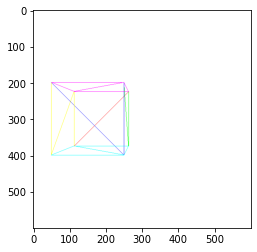

In [15]:
camera = Camera(camera_position = [0,0,0], viewport_size = 1, projection_plane_z = 1)
canvas = Canvas(width=600, height=600)

renderer = Renderer(camera=camera, canvas=canvas)

vertices = []
vertices.append(Vertex(1,1,1))
vertices.append(Vertex(-1,1,1))
vertices.append(Vertex(-1,-1,1))
vertices.append(Vertex(1,-1,1))
vertices.append(Vertex(1,1,-1))
vertices.append(Vertex(-1,1,-1))
vertices.append(Vertex(-1,-1,-1))
vertices.append(Vertex(1,-1,-1))

triangles = []
triangles.append(Triangle(0,1,2,(255,0,0)))
triangles.append(Triangle(0,2,3,(255,0,0)))
triangles.append(Triangle(4,0,3,(0,255,0)))
triangles.append(Triangle(4,3,7,(0,255,0)))
triangles.append(Triangle(5,4,7,(0,0,255)))
triangles.append(Triangle(5,7,6,(0,0,255)))
triangles.append(Triangle(1,5,6,(255,255,0)))
triangles.append(Triangle(1,6,2,(255,255,0)))
triangles.append(Triangle(4,5,1,(255,0,255)))
triangles.append(Triangle(4,1,0,(255,0,255)))
triangles.append(Triangle(2,6,7,(0,255,255)))
triangles.append(Triangle(2,7,3,(0,255,255)))

renderer.render_object(vertices, triangles)
renderer.render()